In [33]:
# Python vision: Python3.5
# @Author: MingZZZZZZZZ
# @Date created: 2019
# @Date modified: 2019
# Description:

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

from statsmodels.stats.stattools import durbin_watson

# example: **************************************************************
filepath = '/home/ming/Documents/dupe/GragersCausalityandVectorRegressiveModelforTimeSeriesForecasting/vspomode_20191022_Midday_Midtown.csv'
df = pd.read_csv(filepath, parse_dates=['timestamp'], index_col='timestamp')
df.drop(['oil_temp', 'gas_path', 'Latitude', 'Longitude', 'intake_temp'], inplace=True, axis=1)
df.dropna(inplace=True)
df.head()

temperature  exhaust_temp  engcool_temp  speed_kmh  \
timestamp                                                                 
2019-11-17 12:12:55         21.4          45.1          67.0        0.0   
2019-11-17 12:12:56         21.3          45.1          67.0        1.7   
2019-11-17 12:12:57         21.4          44.9          67.0        0.0   
2019-11-17 12:12:58         21.3          44.7          67.0        0.0   
2019-11-17 12:12:59         21.4          45.2          67.0        0.0   

                     acc_mps2   vsp  opmode  enginerpm  fuelrate  engine_torq  \
timestamp                                                                       
2019-11-17 12:12:55  0.472222  0.00       1        738  0.000121           51   
2019-11-17 12:12:56 -0.472222 -0.17      11        725  0.000124           51   
2019-11-17 12:12:57  0.000000  0.00       1        700  0.000128           51   
2019-11-17 12:12:58  0.000000  0.00       1        688  0.000134           54   
2019-11-17 12:12:59  0.000000  0.00       1        688  0.000135           56   

                     engine_power  lambda  pems_co2  pems_co  pems_no2  \
timestamp                                                                
2019-11-17 12:12:55          3.98    0.95     1.094  0.00169       0.0   
2019-11-17 12:12:56          3.91    0.95     1.127  0.00162       0.0   
2019-11-17 12:12:57          3.77    0.94     1.158  0.00156       0.0   
2019-11-17 12:12:58          3.90    0.95     1.213  0.00174       0.0   
2019-11-17 12:12:59          4.06    0.95     1.226  0.00201       0.0   

                     pems_no       pems_pn  
timestamp                                   
2019-11-17 12:12:55      0.0  3.728750e+06  
2019-11-17 12:12:56      0.0  3.702323e+06  
2019-11-17 12:12:57      0.0  3.802982e+06  
2019-11-17 12:12:58      0.0  2.351377e+06  
2019-11-17 12:12:59      0.0  1.483018e+06

In [22]:
# plot
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(100,200))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout()
plt.show()

/home/ming/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/home/ming/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/home/ming/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
/home/ming/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
/home/mi

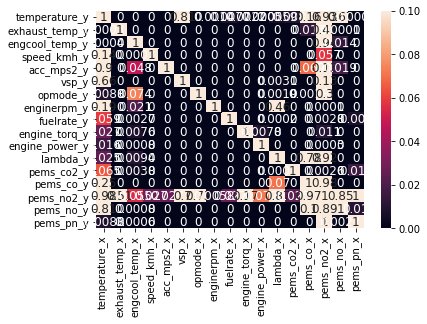

In [34]:
# Granger's causality test
def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.
    :param data: dataframe
        pandas dataframe containing the time series variables
    :param variables : list
        list containing names of the time series variables.
    :param maxlag: int
        the Granger causality test results are calculated for all lags up to maxlag
    :param verbose: bool
        print results if true
    :return: dataframe
        If a given p-value is < significance level (0.05), then, the corresponding X series (column)
        causes the Y (row)
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
            if verbose:
                print('Y = {}, X = {}, P Values = {}'.format(r, c, p_values))
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


causality_df = grangers_causation_matrix(df, variables=df.columns, verbose=False)
sns.heatmap(causality_df, annot=True, annot_kws={'size': 12}, vmax=0.1)
plt.show()


In [36]:
def adjust(val, length= 6): return str(val).ljust(length)
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]

    # Summary
    print('Name :: Test Stat > C(95%) => Signif \n', '--' * 20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' => ', trace > cvt)


cointegration_test(df)

/home/ming/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/tsa/vector_ar/vecm.py:608: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  category=HypothesisTestWarning)


Name :: Test Stat > C(95%) => Signif 
 ----------------------------------------
temperature ::  8416.16   > nan       =>  False
exhaust_temp ::  7046.59   > nan       =>  False
engcool_temp ::  5968.07   > nan       =>  False
speed_kmh ::  5096.85   > nan       =>  False
acc_mps2 ::  4331.23   > nan       =>  False
vsp    ::  3584.34   > 311.1288  =>  True
opmode ::  2936.72   > 263.2603  =>  True
enginerpm ::  2318.2    > 219.4051  =>  True
fuelrate ::  1724.59   > 179.5199  =>  True
engine_torq ::  1163.16   > 143.6691  =>  True
engine_power ::  682.68    > 111.7797  =>  True
lambda ::  236.53    > 83.9383   =>  True
pems_co2 ::  130.41    > 60.0627   =>  True
pems_co ::  46.31     > 40.1749   =>  True
pems_no2 ::  3.84      > 24.2761   =>  False
pems_no ::  0.21      > 12.3212   =>  False
pems_pn ::  0.04      > 4.1296    =>  False


In [37]:
# split dataset
nobs = 300
df_train, df_test = df[0:-nobs], df[-nobs:]
# Check size
print(df_train.shape)
print(df_test.shape)

# # do difference until all variable is stationary
# df_diff = df_train.diff().dropna()
# # Second Differencing
# df_diff = df_diff.diff().dropna()

(7013, 17)
(300, 17)


In [38]:
# ADF Test (stationarity check) 
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    # Print Summary
    print('Augmented Dickey-Fuller Test on "{}"'.format(name), "\n", '-'*47)
    print(' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(' Significance Level = {}'.format(signif))
    print(' Test Statistic = {}'.format(output["test_statistic"]))
    print(' No. Lags Chosen = {}'.format(output["n_lags"]))
    
    for key,val in r[4].items():
        print(' Critical value {} = {}'.format(adjust(key), round(val, 3)))
    if p_value <= signif:
        print(" => P-Value = {}. Rejecting Null Hypothesis.".format(p_value))
        print(" => Series is Stationary.")
    else:
        print(" => P-Value = {}. Weak evidence to reject the Null Hypothesis.".format(p_value))
        print(" => Series is Non-Stationary.")


for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Augmented Dickey-Fuller Test on "temperature" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -5.6057
 No. Lags Chosen = 35
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Augmented Dickey-Fuller Test on "exhaust_temp" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -5.0403
 No. Lags Chosen = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Augmented Dickey-Fuller Test on "engcool_temp" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -9.4146
 No. 

In [39]:
# model*******************************************************
model = VAR(df_train)
for i in range(1, 10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


/home/ming/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


Lag Order = 1
AIC :  -81.94316361270275
BIC :  -81.64399850384812
FPE :  2.5854509120119817e-36
HQIC:  -81.84008499157562 

Lag Order = 2
AIC :  -55.35835248336145
BIC :  -54.77657168236186
FPE :  9.08183488024266e-25
HQIC:  -55.157895976853546 

Lag Order = 3
AIC :  -55.8314668576832
BIC :  -54.96700149472382
FPE :  5.658535388268664e-25
HQIC:  -55.53360733985859 

Lag Order = 4
AIC :  -55.177593162639084
BIC :  -54.030374340944846
FPE :  1.088129190454966e-24
HQIC:  -54.78230549744024 

Lag Order = 5
AIC :  -55.48381919129966
BIC :  -54.053777987120874
FPE :  8.011108011013163e-25
HQIC:  -54.991078232541916 

Lag Order = 6
AIC :  -52.38809427775603
BIC :  -50.675161740353886
FPE :  1.770742346262122e-23
HQIC:  -51.79787486912207 

Lag Order = 7
AIC :  -53.81372989623549
BIC :  -51.81783704786764
FPE :  4.256168299405133e-24
HQIC:  -53.1260068712698 

Lag Order = 8
AIC :  -52.19917084954462
BIC :  -49.9202486854507
FPE :  2.139069858697816e-23
HQIC:  -51.413919031647964 

Lag Order = 

In [40]:
x = model.select_order(maxlags=12)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [41]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Nov, 2019
Time:                     19:02:25
--------------------------------------------------------------------
No. of Equations:         17.0000    BIC:                   -81.6440
Nobs:                     7012.00    HQIC:                  -81.8401
Log likelihood:           118456.    FPE:                2.58545e-36
AIC:                     -81.9432    Det(Omega_mle):     2.47519e-36
--------------------------------------------------------------------
Results for equation temperature
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  18.492491         0.614415           30.098           0.000
L1.temperature          0.480994         0.010488           45.861           0.000
L1.exhaust_temp        -0.001871         0.000

In [42]:
# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
# If there is any correlation left in the residuals, then, there is some pattern in the time series
# that is still left to be explained by the model. In that case, the typical course of action is to
# either increase the order of the model or induce more predictors into the system or look for
# a different algorithm to model the time series.
out = durbin_watson(model_fitted.resid)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))


temperature : 2.32
exhaust_temp : 1.53
engcool_temp : 2.12
speed_kmh : 1.88
acc_mps2 : 1.98
vsp    : 2.17
opmode : 2.12
enginerpm : 1.92
fuelrate : 1.86
engine_torq : 1.75
engine_power : 2.24
lambda : 0.88
pems_co2 : 1.86
pems_co : 1.13
pems_no2 : 0.67
pems_no : 1.53
pems_pn : 1.42


In [48]:
# predict
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)
# Input data for forecasting
forecast_input = df_train.values[-lag_order:]

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast.head()


1


temperature_2d  exhaust_temp_2d  engcool_temp_2d  \
timestamp                                                               
2019-11-17 14:09:48       16.767543       138.462341        85.940875   
2019-11-17 14:09:49       16.521119       137.336031        85.872516   
2019-11-17 14:09:50       16.413380       135.684558        85.802498   
2019-11-17 14:09:51       16.369961       133.973181        85.737587   
2019-11-17 14:09:52       16.353773       132.419083        85.682161   

                     speed_kmh_2d  acc_mps2_2d    vsp_2d  opmode_2d  \
timestamp                                                             
2019-11-17 14:09:48     16.300000     1.020687  7.404275  14.312925   
2019-11-17 14:09:49     19.974475     0.768137  7.729476  14.764421   
2019-11-17 14:09:50     22.739769     0.541899  7.312591  14.763017   
2019-11-17 14:09:51     24.690607     0.359290  6.671332  14.541120   
2019-11-17 14:09:52     25.984051     0.224584  6.048422  14.235828   

                     enginerpm_2d  fuelrate_2d  engine_torq_2d  \
timestamp                                                        
2019-11-17 14:09:48   1719.603650     0.000546      120.864807   
2019-11-17 14:09:49   1778.857469     0.000485      108.463483   
2019-11-17 14:09:50   1772.759960     0.000427       92.946383   
2019-11-17 14:09:51   1725.294013     0.000380       79.183926   
2019-11-17 14:09:52   1657.250763     0.000344       68.806607   

                     engine_power_2d  lambda_2d  pems_co2_2d  pems_co_2d  \
timestamp                                                                  
2019-11-17 14:09:48        21.609071   0.915828     4.964520    0.003009   
2019-11-17 14:09:49        20.308486   0.868689     4.401946    0.002996   
2019-11-17 14:09:50        17.868411   0.835660     3.880581    0.001489   
2019-11-17 14:09:51        15.352970   0.819963     3.456342   -0.000445   
2019-11-17 14:09:52        13.223853   0.818997     3.135664   -0.002211   

                      pems_no2_2d  pems_no_2d    pems_pn_2d  
timestamp                                                    
2019-11-17 14:09:48  4.727868e-08    0.000021 -1.209324e+08  
2019-11-17 14:09:49  4.824121e-08    0.000013 -1.203732e+09  
2019-11-17 14:09:50  4.811655e-08    0.000008 -1.910093e+09  
2019-11-17 14:09:51  4.568543e-08    0.000005 -2.219563e+09  
2019-11-17 14:09:52  4.125427e-08    0.000004 -2.207454e+09

In [32]:
# # transformation to real prediction
# def invert_transformation(df_train, df_forecast, second_diff=False):
#     """Revert back the differencing to get the forecast to original scale."""
#     df_fc = df_forecast.copy()
#     columns = df_train.columns
#     for col in columns:
#         # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
#         # Roll back 1st Diff
#         df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
#     return df_fc
# 
# 
# df_results = invert_transformation(df_train, df_forecast, second_diff=True)
# df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast', 'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]


rgnp_forecast  pgnp_forecast  ulc_forecast  gdfco_forecast  \
date                                                                     
1988-10-01    4123.022456    3996.950774    181.095993      132.965657   
1989-01-01    4168.382626    4021.613582    182.262108      134.389097   
1989-04-01    4234.135476    4046.567687    183.819036      135.678050   
1989-07-01    4262.471728    4071.240850    185.743875      137.069799   

            gdf_forecast  gdfim_forecast  gdfcf_forecast  gdfce_forecast  
date                                                                      
1988-10-01    126.395854      106.604119      125.082773       93.186939  
1989-01-01    128.056341      108.365461      127.283708       96.603854  
1989-04-01    129.230756      109.977252      128.246409       97.675545  
1989-07-01    130.738542      111.086940      129.678579       99.264661

KeyError: 'temperature_forecast'

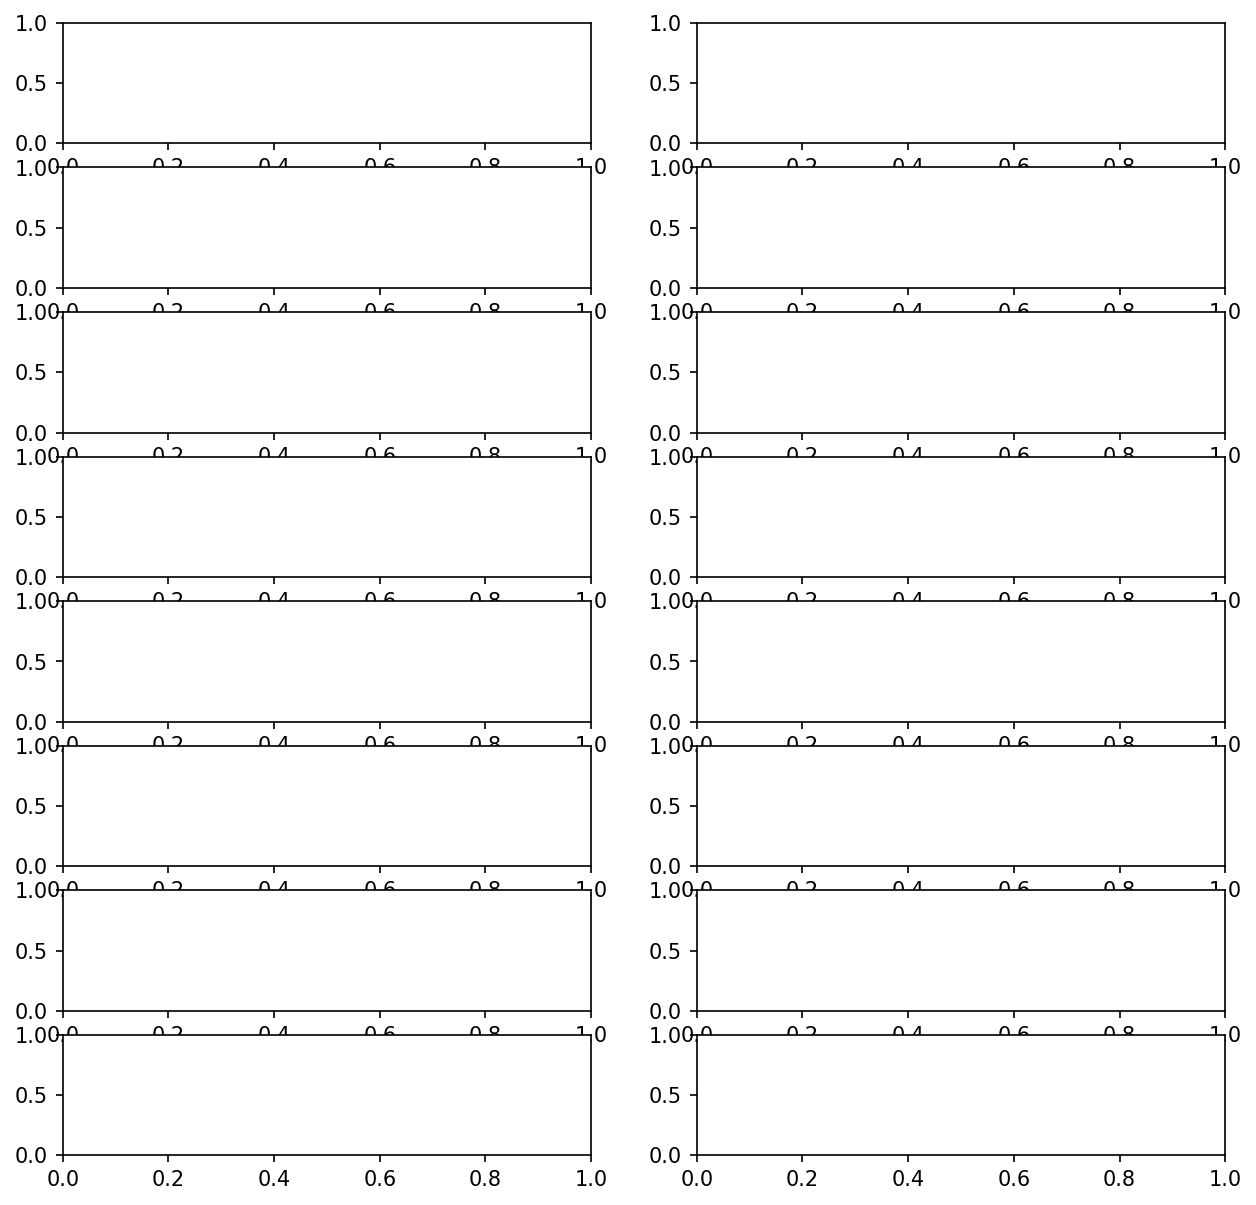

In [49]:
df_results = df_forecast
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

In [34]:
# Evaluation
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual) # ME
    mae = np.mean(np.abs(forecast - actual)) # MAE
    mpe = np.mean((forecast - actual)/actual) # MPE
    rmse = np.mean((forecast - actual)**2)**.5 # RMSE
    corr = np.corrcoef(forecast, actual)[0,1] # corr
    # MAPE
    mins = np.amin(np.hstack([forecast[:,None],
    actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
    actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  0.0192
mae    :  79.1031
minmax :  0.0188
me     :  79.1031
corr   :  0.9849
mpe    :  0.0192
rmse   :  82.0245

Forecast Accuracy of: pgnp
mape   :  0.0005
mae    :  2.0432
minmax :  0.0005
me     :  2.0432
corr   :  1.0
mpe    :  0.0005
rmse   :  2.146

Forecast Accuracy of: ulc
mape   :  0.0081
mae    :  1.4947
minmax :  0.0081
me     :  -1.4947
corr   :  0.963
mpe    :  -0.0081
rmse   :  1.6856

Forecast Accuracy of: gdfco
mape   :  0.0033
mae    :  0.4384
minmax :  0.0032
me     :  0.0007
corr   :  0.9407
mpe    :  0.0
rmse   :  0.5169

Forecast Accuracy of: gdf
mape   :  0.0023
mae    :  0.29
minmax :  0.0022
me     :  0.2554
corr   :  0.9905
mpe    :  0.002
rmse   :  0.3392

Forecast Accuracy of: gdfim
mape   :  0.0097
mae    :  1.06
minmax :  0.0096
me     :  -0.4166
corr   :  0.807
mpe    :  -0.0038
rmse   :  1.0826

Forecast Accuracy of: gdfcf
mape   :  0.0036
mae    :  0.4604
minmax :  0.0036
me     :  -0.0271
corr   :  0.9713
mpe    :  -